# Подключение библиотек

In [33]:
import numpy as np

import torch
from torch import nn
import statsmodels.api as sm

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%matplotlib inline
import matplotlib.pyplot as plt

import torchsde
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams.update({'font.size': 16})

# Генерация сэмпла

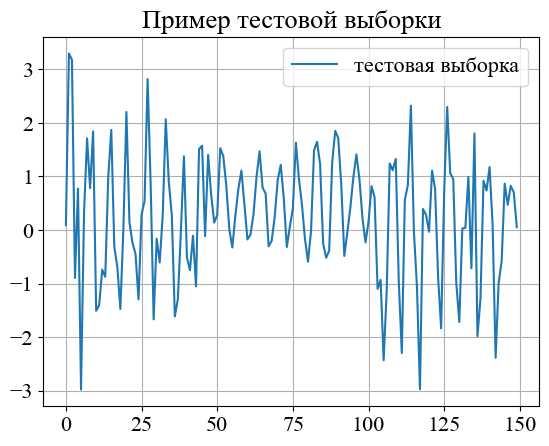

In [61]:
N = 50
samples = np.arange(N)

sinuses = np.sin(samples) # синусы

X = sinuses + np.random.normal(loc=0, scale=1, size=N)
Y = sinuses + np.random.normal(loc=0, scale=1, size=N)
Z = sinuses + np.random.uniform(low=0, high=1, size=N)

vals = X
vals = np.append(vals, Z)
vals = np.append(vals, Y)

vals_size = 3 * N


plt.title('Пример тестовой выборки')
plt.plot(np.arange(vals_size), vals, label='тестовая выборка')

plt.legend()
plt.grid()

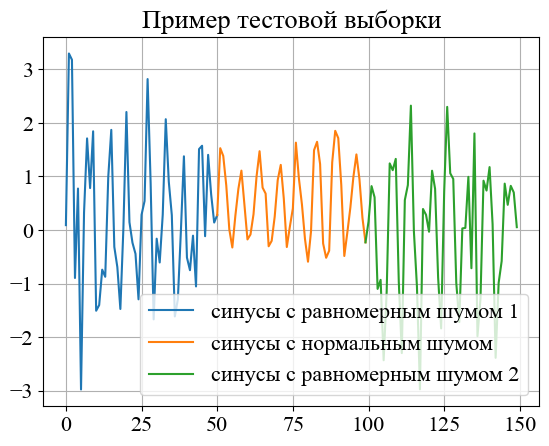

In [62]:
plt.title('Пример тестовой выборки')
plt.plot(np.arange(len(X) + 1), vals[:len(X)+1], label='синусы с равномерным шумом 1')
plt.plot(np.arange(len(Z)) + len(X), Z, label='синусы с нормальным шумом')
plt.plot(np.arange(len(Y) + 1) + len(X) + len(Z) - 1, vals[len(X) + len(Z) - 1:], label='синусы с равномерным шумом 2')
plt.legend()
plt.grid()

# Настройка класса модели Neural SDE

In [63]:
brownian_size = 2
state_size = vals_size
batch_size = 50 # 50 прогнозов одномерного временного ряда из N элементов

class SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'stratonovich'

    def __init__(self):
        super().__init__()
        self.mu = torch.nn.Linear(state_size, 
                                  state_size, dtype=float)
        self.sigma = torch.nn.Linear(state_size, 
                                     state_size * brownian_size, dtype=float)
        self.gamma = nn.Parameter(torch.tensor(0.1), requires_grad=True)
        
    # Drift
    def f(self, t, y):
        return torch.cos(t) * self.mu(y)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        return torch.exp(-self.gamma * t) * self.sigma(y).view(batch_size, 
                                  state_size, 
                                  brownian_size)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

sde = SDE().to(device)

# Определение вспомогательных функций для проведения эксперимента

In [64]:
def train_SDE(model, values, iters_cnt_for_study):
    t_size = len(values)

    ts = torch.linspace(0, 1, t_size).to(device) # разметка временного диапазона
    y0 = torch.from_numpy(np.tile(vals, batch_size)).view(batch_size, state_size).to(device) # начальная точка временного ряда
    optimizer = torch.optim.SGD(sde.parameters(), lr=0.01)

    losses = np.array([], dtype=float)
    for i in range(iters_cnt_for_study):
        predict = torchsde.sdeint_adjoint(sde, y0, ts)  
        target = torch.tensor(values)
        loss = ((target - predict) ** 2).mean()

        losses = np.append(losses, loss.detach().numpy())
        
        loss.backward()
        optimizer.step()  # обновляем параметры сети
        optimizer.zero_grad()  # обнуляем посчитанные градиенты параметров
    return losses

def predict_SDE(model, values, window_size):
    t_size = len(values)
    
    hankel_matrix = []
    cur_row = values
    hankel_matrix.append(cur_row)
    
    for step in range(window_size):
        ts = torch.linspace(0, 1, t_size).to(device) # разметка временного диапазона
        y0 = torch.from_numpy(np.tile(cur_row, batch_size)).view(batch_size, state_size).to(device) # начальная точка временного ряда
        
        predict = torchsde.sdeint_adjoint(sde, y0, ts)  
        target = torch.tensor(values)  

        ys = predict
        ts = ts.cpu()

        
        avg = np.mean(np.mean(np.array([sample.detach().cpu().numpy() for i, sample in enumerate(ys)], dtype=float), axis=0), axis=0)
        cur_row = np.roll(cur_row, -1)
        cur_row[-1] = avg[-1]

        hankel_matrix.append(cur_row)


    return np.array(hankel_matrix) 

def get_params_from_hankel(hankel_matrix):
    len_vals = len(hankel_matrix[0])
    window_size = len(hankel_matrix)

    original = hankel_matrix[0]
    prediction =hankel_matrix[-1][(len_vals - window_size):]

    hank = hankel_matrix.transpose()
    means = np.mean(hank, axis=1)
    dysps = np.mean(hank ** 2, axis = 1) - means ** 2
    
    return original, prediction, means, dysps

# Обучение модели на временном ряду

In [65]:
losses = train_SDE(sde, vals, 100)

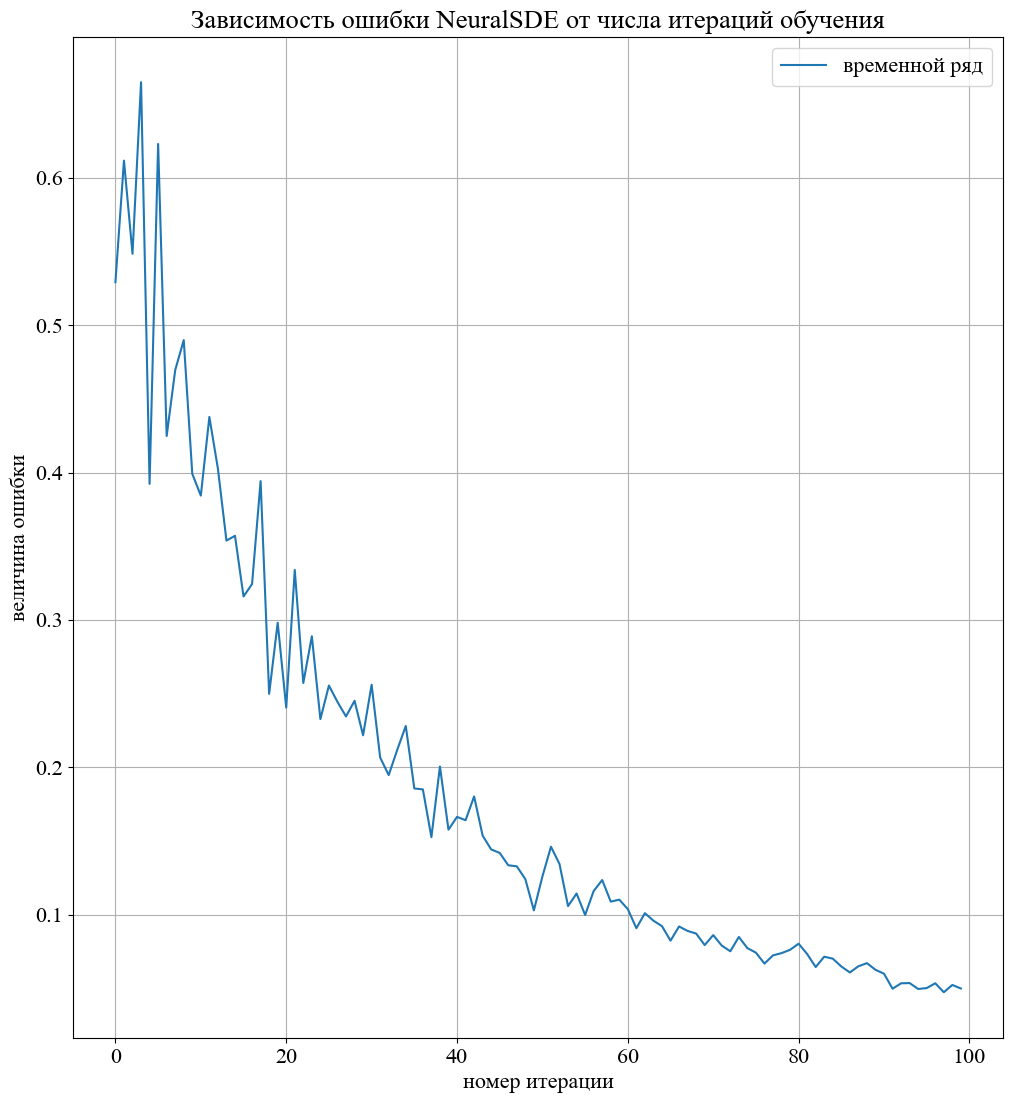

In [66]:
plt.figure(figsize = (12, 13))

plt.plot(np.arange(len(losses)), losses, label='временной ряд')

plt.title('Зависимость ошибки NeuralSDE от числа итераций обучения')
plt.xlabel('номер итерации')
plt.ylabel('величина ошибки')
plt.legend()
plt.grid()

# Построение/визуализация прогнозов. Нахождение точек разладки

In [67]:
def search_breakdown_points(trained_model, values, window_size):
    Hankel_Mat = predict_SDE(sde, vals, window_size)
    orig, cont, means, dysps = get_params_from_hankel(Hankel_Mat)
    
    points_x = np.array([], dtype=float)
    points_y = np.array([], dtype=float)
    cnt_points = 0
    
    for i in range(len(orig)):
        if (orig[i] < means[i] - dysps[i] or orig[i] > means[i] + dysps[i]):
            points_x = np.append(points_x, i)
            points_y = np.append(points_y, orig[i])
            cnt_points += 1
            
    return cnt_points, points_x, points_y

In [68]:
window_sizes = np.arange(5, 80, 15)

counts = np.array([], dtype=float)
p_x = []
p_y = []

for w in window_sizes:
    cnt, px_t, py_t = search_breakdown_points(sde, vals, w)
    
    counts = np.append(counts, cnt)
    p_x.append(px_t)
    p_y.append(py_t)

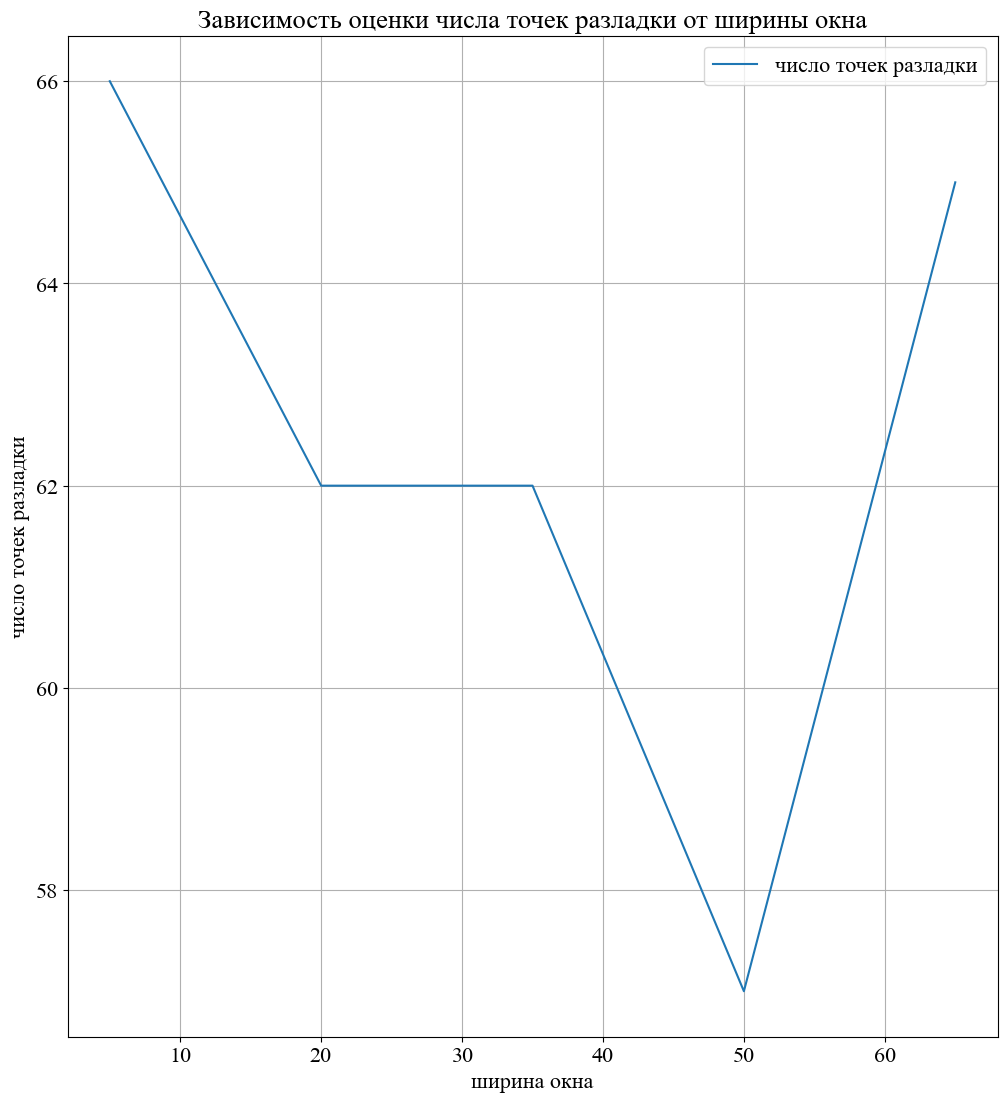

In [69]:
plt.figure(figsize = (12, 13))

plt.plot(window_sizes, counts, label='число точек разладки')


plt.title('Зависимость оценки числа точек разладки от ширины окна')
plt.xlabel('ширина окна')
plt.ylabel('число точек разладки')
plt.legend()
plt.grid()

In [70]:
final_window_size = window_sizes[np.argmin(counts)]
print('Итого для проведения эксперимента выбрана ширина окна',str(final_window_size),'как самая стабильная.')

Итого для проведения эксперимента выбрана ширина окна 50 как самая стабильная.


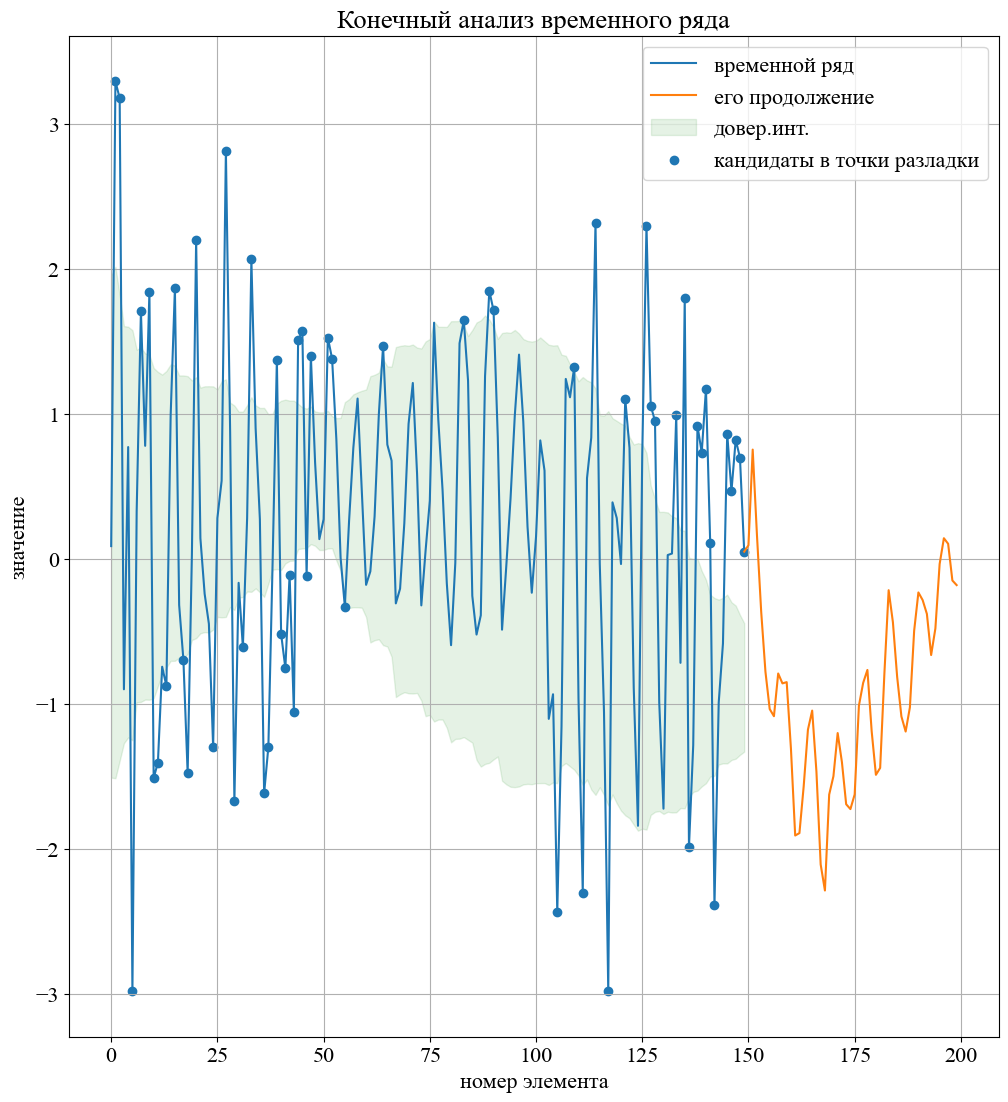

In [71]:
Hankel_Mat = predict_SDE(sde, vals, final_window_size)
orig, cont, means, dysps = get_params_from_hankel(Hankel_Mat)

plt.figure(figsize = (12, 13))

plt.plot(np.arange(len(orig)), orig, label='временной ряд')
plt.plot(np.arange(len(cont)) + len(orig) - 1, cont, label='его продолжение')
plt.fill_between(np.arange(len(orig)), means - dysps, means + dysps, color='green',alpha=0.1, label='довер.инт.')
plt.scatter(p_x[np.argmin(counts)], p_y[np.argmin(counts)], label='кандидаты в точки разладки')

plt.title('Конечный анализ временного ряда')
plt.xlabel('номер элемента')
plt.ylabel('значение')
plt.legend()
plt.grid()